# Amazon Titan Image Generator v2 の全機能を利用して画像を生成する

[Qiita](https://qiita.com/ren8k) の検証記事で利用したコードです．

In [25]:
import base64
import io
import json

import boto3
from PIL import Image


def generate_image(
    payload: dict,
    num_image: int = 1,
    cfg_scale: float = 10.0,
    seed: int = 42,
    model_id: str = "amazon.titan-image-generator-v2:0",
) -> None:

    client = boto3.client("bedrock-runtime", region_name="us-west-2")
    body = json.dumps(
        {
            **payload,
            "imageGenerationConfig": {
                "numberOfImages": num_image,  # Range: 1 to 5
                "quality": "premium",  # Options: standard/premium
                "height": 1024,  # Supported height list above
                "width": 1024,  # Supported width list above
                "cfgScale": cfg_scale,  # Range: 1.0 (exclusive) to 10.0
                "seed": seed,  # Range: 0 to 214783647
            },
        }
    )

    response = client.invoke_model(
        body=body,
        modelId=model_id,
        accept="application/json",
        contentType="application/json",
    )

    response_body = json.loads(response.get("body").read())
    base64_image = response_body.get("images")[0]
    base64_bytes = base64_image.encode("ascii")
    image_bytes = base64.b64decode(base64_bytes)

    image = Image.open(io.BytesIO(image_bytes))
    image.show()

In [26]:
input_image_path = "../images/input/dogcat.png"
mask_dog_image_path = "../images/mask/mask_dog.png"
mask_cat_image_path = "../images/mask/mask_cat.png"
mask_dog_rectangle_image_path = "../images/mask/mask_dog_rectangle.png"

### 画像生成

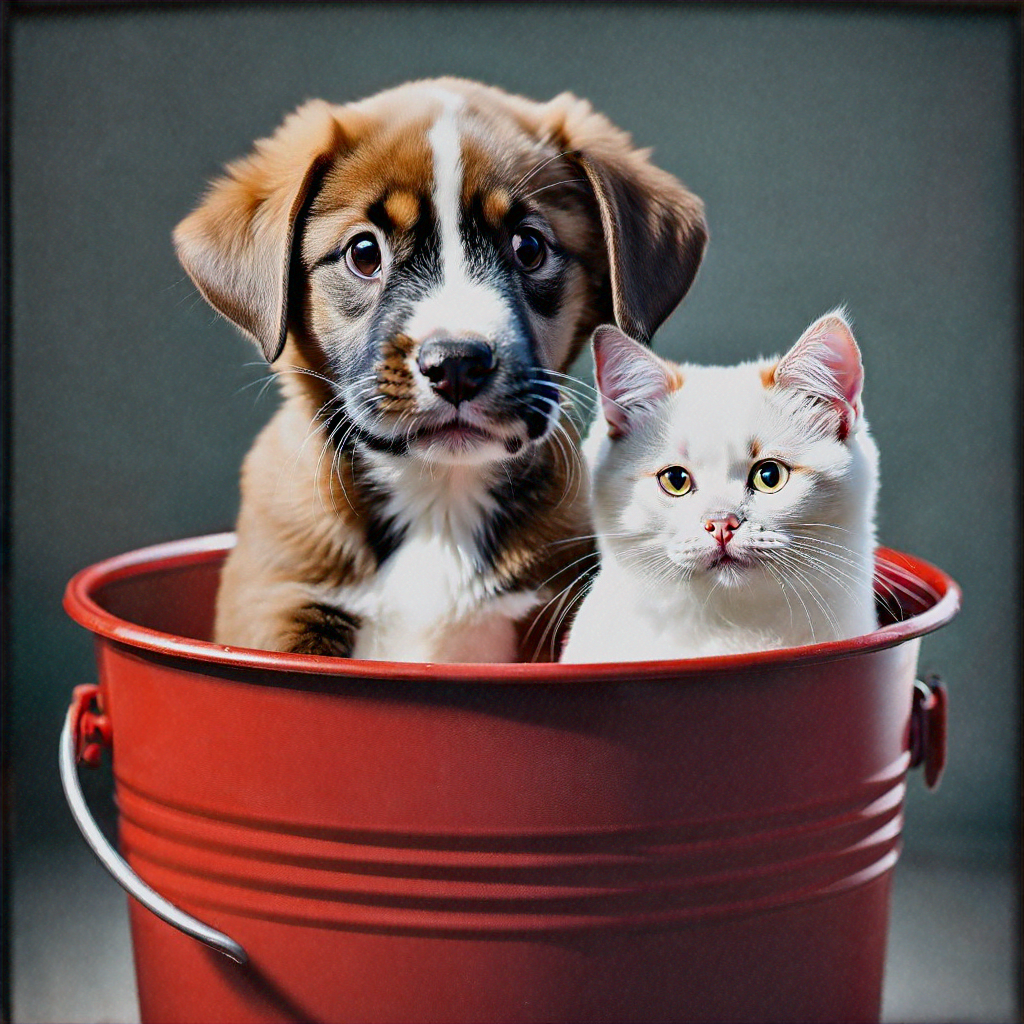

In [27]:
generate_image(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": "A cute brown puppy and a white cat inside a red bucket",  # Required
            "negativeText": "bad quality, low res, noise",  # Optional
        },
    }
)

### 画像コンディショニング(Canny Edge)

In [ ]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread(input_image_path, 0)
edges = cv2.Canny(img, 100, 200)

plt.subplot(121), plt.imshow(img, cmap="gray")
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(edges, cmap="gray")
plt.title("Edge Image"), plt.xticks([]), plt.yticks([])

plt.show()

In [ ]:
import cv2
import matplotlib.pyplot as plt


def save_image(image, file_path: str) -> None:
    cv2.imwrite(file_path, image)


def canny_edge_detection(image_path: str, low_threshold: int, high_threshold: int):
    """
    Canny法によるエッジ検出を行う関数
    :param image_path: 画像ファイルのパス
    :param low_threshold: 二重しきい値処理の低い方の閾値
    :param high_threshold: 二重しきい値処理の高い方の閾値
    :return: エッジ検出結果の画像
    """
    original_image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, low_threshold, high_threshold)
    return original_image, edges


def display_images(original_image, edge_image):
    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title("Original RGB Image"), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(edge_image, cmap="gray")
    plt.title("Edge Image"), plt.xticks([]), plt.yticks([])
    plt.show()


# 例: Canny法の実行、表示、および画像の保存
image_path = input_image_path
low_threshold = 100
high_threshold = 200

original_image, edge_image = canny_edge_detection(
    image_path, low_threshold, high_threshold
)

display_images(original_image, edge_image)
save_image(edge_image, "/app/sam2/notebooks/images/dogcat_edge.png")

In [ ]:
with open(input_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode("utf8")

generate_image(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": "A cute black puppy and a brown cat inside a blue bucket",
            "conditionImage": input_image,
            "negativeText": "bad quality, low res, noise",  # Optional
            "controlMode": "CANNY_EDGE",  # Optional: CANNY_EDGE | SEGMENTATION
            "controlStrength": 0.7,  # Optional: weight given to the condition image. Default: 0.7
        },
    },
    seed=5,
)

### 画像コンディショニング(Segmentation)

In [ ]:
with open(input_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode("utf8")

generate_image(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": "A cute black puppy and a brown cat inside a blue bucket",
            "conditionImage": input_image,
            "negativeText": "bad quality, low res, noise",  # Optional
            "controlMode": "SEGMENTATION",  # Optional: CANNY_EDGE | SEGMENTATION
            "controlStrength": 0.7,  # Optional: weight given to the condition image. Default: 0.7
        },
    },
    seed=1,
)

### インペインティング(Default)

In [ ]:
with open(input_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode("utf8")

generate_image(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": "A cute black puppy and a brown cat inside a blue bucket",
            "conditionImage": input_image,
            "negativeText": "bad quality, low res, noise",  # Optional
            "controlMode": "SEGMENTATION",  # Optional: CANNY_EDGE | SEGMENTATION
            "controlStrength": 0.7,  # Optional: weight given to the condition image. Default: 0.7
        },
    },
    seed=50,
)

### インペインティング(Default)

#### mask prompt を利用する場合

In [ ]:
with open(input_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode("utf8")

generate_image(
    {
        "taskType": "INPAINTING",
        "inPaintingParams": {
            "text": "A black cat inside a red bucket, background is dim green nature",
            "image": input_image,  # Required
            "maskPrompt": "A brown puppy",  # One of "maskImage" or "maskPrompt" is required
            "negativeText": "deformed ears, bad quality, low res, noise",  # Optional
        },
    },
    seed=8,
)

#### mask image を利用する場合

In [ ]:
with open(input_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode("utf8")

with open(mask_dog_image_path, "rb") as image_file:
    mask_image = base64.b64encode(image_file.read()).decode("utf8")

generate_image(
    {
        "taskType": "INPAINTING",
        "inPaintingParams": {
            "text": "A black cat inside a red bucket, background is dim green nature",
            "image": input_image,  # Required
            "maskImage": mask_image,  # One of "maskImage" or "maskPrompt" is required
            "negativeText": "deformed ears, bad quality, low res, noise",  # Optional
        },
    },
    seed=7,
)

### インペインティング(Removal)

#### mask prompt を利用する場合

In [ ]:
with open(input_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode("utf8")

generate_image(
    {
        "taskType": "INPAINTING",
        "inPaintingParams": {
            "image": input_image,  # Required
            "maskPrompt": "A white cat",  # One of "maskImage" or "maskPrompt" is required
            "negativeText": "bad quality, low res, noise",  # Optional
        },
    },
    seed=7,
)

#### mask image を利用する場合

In [ ]:
with open(input_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode("utf8")

with open(mask_cat_image_path, "rb") as image_file:
    mask_image = base64.b64encode(image_file.read()).decode("utf8")

generate_image(
    {
        "taskType": "INPAINTING",
        "inPaintingParams": {
            "image": input_image,  # Required
            "maskImage": mask_image,  # One of "maskImage" or "maskPrompt" is required
            "negativeText": "bad quality, low res, noise",  # Optional
        },
    },
    seed=7,
)

### アウトペインティング(Default)

#### mask prompt を利用する場合

In [ ]:
with open(input_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode("utf8")

generate_image(
    {
        "taskType": "OUTPAINTING",
        "outPaintingParams": {
            "text": "A dog riding in a small boat.",
            "image": input_image,  # Required
            "maskPrompt": "A cute brown puppy",  # One of "maskImage" or "maskPrompt" is required
            "negativeText": "bad quality, low res, noise",  # Optional
            "outPaintingMode": "DEFAULT",  # One of "PRECISE" or "DEFAULT"
        },
    },
    seed=45,
)

#### mask image を利用する場合

In [ ]:
with open(input_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode("utf8")

with open(mask_dog_image_path, "rb") as image_file:
    mask_image = base64.b64encode(image_file.read()).decode("utf8")

generate_image(
    {
        "taskType": "OUTPAINTING",
        "outPaintingParams": {
            "text": "A dog riding in a small boat.",
            "image": input_image,  # Required
            "maskImage": mask_image,  # One of "maskImage" or "maskPrompt" is required
            "negativeText": "bad quality, low res, noise",  # Optional
            "outPaintingMode": "DEFAULT",  # One of "PRECISE" or "DEFAULT"
        },
    },
    seed=45,
)

In [ ]:
with open(input_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode("utf8")

with open(mask_dog_rectangle_image_path, "rb") as image_file:
    mask_image = base64.b64encode(image_file.read()).decode("utf8")

generate_image(
    {
        "taskType": "OUTPAINTING",
        "outPaintingParams": {
            "text": "A dog riding in a small boat.",
            "image": input_image,  # Required
            "maskImage": mask_image,  # One of "maskImage" or "maskPrompt" is required
            "negativeText": "bad quality, low res, noise",  # Optional
            "outPaintingMode": "DEFAULT",  # One of "PRECISE" or "DEFAULT"
        },
    },
    seed=40,
)

### アウトペインティング(Precise)

#### mask promptを利用する場合

In [ ]:
with open(input_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode("utf8")

generate_image(
    {
        "taskType": "OUTPAINTING",
        "outPaintingParams": {
            "text": "A dog riding in a small boat.",
            "image": input_image,  # Required
            "maskPrompt": "A cute brown puppy",  # One of "maskImage" or "maskPrompt" is required
            "negativeText": "bad quality, low res, noise",  # Optional
            "outPaintingMode": "PRECISE",  # One of "PRECISE" or "DEFAULT"
        },
    },
    seed=45,
)

#### mask image を利用する場合

In [ ]:
with open(input_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode("utf8")

with open(mask_dog_image_path, "rb") as image_file:
    mask_image = base64.b64encode(image_file.read()).decode("utf8")

generate_image(
    {
        "taskType": "OUTPAINTING",
        "outPaintingParams": {
            "text": "A dog riding in a small boat.",
            "image": input_image,  # Required
            "maskImage": mask_image,  # One of "maskImage" or "maskPrompt" is required
            "negativeText": "bad quality, low res, noise",  # Optional
            "outPaintingMode": "PRECISE",  # One of "PRECISE" or "DEFAULT"
        },
    },
    seed=45,
)

In [ ]:
with open(input_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode("utf8")

with open(mask_dog_rectangle_image_path, "rb") as image_file:
    mask_image = base64.b64encode(image_file.read()).decode("utf8")

generate_image(
    {
        "taskType": "OUTPAINTING",
        "outPaintingParams": {
            "text": "A dog riding in a small boat.",
            "image": input_image,  # Required
            "maskImage": mask_image,  # One of "maskImage" or "maskPrompt" is required
            "negativeText": "bad quality, low res, noise",  # Optional
            "outPaintingMode": "PRECISE",  # One of "PRECISE" or "DEFAULT"
        },
    },
    seed=49,
)

In [19]:
def shrink_image(img_path, result_path):
    # 画像の読み込み
    with open(img_path, "rb") as image_file:
        image = Image.open(image_file)
        image.load()  # ここで画像データをメモリに読み込む

    # 画像を512x512にリサイズ
    resized_image = image.resize((512, 512))

    # 白い背景の512x512のキャンバスを作成
    white_background = Image.new("RGB", (1024, 1024), (255, 255, 255))

    # リサイズした画像を白い背景の中央に貼り付け
    white_background.paste(resized_image, (0, 0))  # (0, 0)は背景のどこに貼るかを指定

    # マスクの場合、ピクセル値を0または255にする（2値化）
    if "mask" in result_path:
        white_background = white_background.convert("L")  # グレースケールに変換
        threshold = 128  # 二値化の閾値
        white_background = white_background.point(lambda p: 255 if p > threshold else 0)

    # 画像を保存
    white_background.save(result_path)

In [ ]:
# 画像の読み込み
mask_path = "../images/mask/mask_combined.png"
resized_image_path = "../images/input/resized_dogcat.png"
resized_mask_path = "../images/mask/resized_mask_combined.png"

shrink_image(input_image_path, resized_image_path)
shrink_image(mask_path, resized_mask_path)

# リサイズした画像をBase64エンコード
with open(resized_image_path, "rb") as resized_file:
    input_image = base64.b64encode(resized_file.read()).decode("utf8")

with open(resized_mask_path, "rb") as image_file:
    mask_image = base64.b64encode(image_file.read()).decode("utf8")

generate_image(
    {
        "taskType": "OUTPAINTING",
        "outPaintingParams": {
            "text": "ocean",
            "image": input_image,  # Required
            # "maskPrompt": "A cute brown puppy and a white cat inside a red bucket",  # One of "maskImage" or "maskPrompt" is required
            "maskImage": mask_image,  # One of "maskImage" or "maskPrompt" is required
            "negativeText": "bad quality, low res, noise",  # Optional
            "outPaintingMode": "PRECISE",  # One of "PRECISE" or "DEFAULT"
        },
    },
    seed=42,
)

### イメージバリエーション

In [ ]:
with open(input_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode("utf8")

generate_image(
    {
        "taskType": "IMAGE_VARIATION",
        "imageVariationParams": {
            "text": "A cute brown puppy and a white cat inside a red bucket",  # Optional
            "images": [input_image],  # Required
            "negativeText": "bad quality, low res, noise",  # Optional
            "similarityStrength": 0.7,  # Range: 0.2 to 1.0
        },
    },
    seed=7,
)

### カラーパレットによる画像ガイダンス

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
fig.patch.set_facecolor("white")

colorlist = ["#FFA500", "#87CEEB"]
x = np.arange(1, len(colorlist) + 1)
height = np.ones(len(colorlist))
plt.gca().axes.get_xaxis().set_visible(False)
# 図の枠線（スパイン）を非表示にする
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.barh(x, height, color=colorlist, tick_label=colorlist, align="center")
# plt.savefig("../images/output/color_codes.png")

In [ ]:
with open(input_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode("utf8")

generate_image(
    {
        "taskType": "COLOR_GUIDED_GENERATION",
        "colorGuidedGenerationParams": {
            "text": "A cute brown puppy and a white cat inside a blue bucket, an orange sunset in the evening",
            "negativeText": "bad quality, low res, noise",  # Optional
            "referenceImage": input_image,  # Optional
            "colors": ["#FFA500", "#87CEEB"],  # list of color hex codes
        },
    },
    seed=70,
)

In [ ]:
with open(input_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode("utf8")

generate_image(
    {
        "taskType": "BACKGROUND_REMOVAL",
        "backgroundRemovalParams": {
            "image": input_image,
        },
    },
)